# Optimising OpenCL applications

Optimal performance for OpenCL applications is a complex multi-dimensional problem. It depends not only on peak utilisation of compute units, but also the timeliness and speed that memory is passed in and out of compute units. It is a general rule that vendor-specific libraries are the best way to achieve optimal compute performance, however for OpenCL these libraries are often not available. At the same time OpenCL implementations and their underlying hardware have smart technologies to optimise processing for commonly used computing operations, and sometimes the simplest approach works best. At other times better compute performance comes at a significant increase in complexity of the program. CPU's and GPU's architectures are optimsed for different ways of computing. This means that a kernel that performs well on a CPU might perform poorly on a GPU, and vice-versa. Experimentation is the key. In the following sections we will try a number of experiments and see what kind of difference they make to the matrix multiplication problem.

## Fundamentals of CPU and GPU architectures

It is helpful to first cover the fundamentals of computer architectures and explore differences between CPU's and GPU's. 

### Hardware threads and processing elements

From the introduction we have seen that that a processor is partioned into cores and each core provides a number of hardware threads that become the processing elements for an OpenCL kernel. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/Intel-8th-Gen Core-3.jpg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A processor die showing an eighth-generation <span>Intel&trade;</span> <span>Core&trade;</span> processor. Image used with permission courtesy of Intel Corporation. </figcaption>
</figure>

Cores have a clock cycle and can perform a limited number of instructions per cycle. During a computation instructions such as math commands are executed on the hardware threads, using memory that is passed in and out of the core from a hierarchy of caches. If this memory does not arrive on time, or get disposed of on time, then the hardware threads will stall and peak theoretical performance will not be acheived.

### Cache topics

#### Hierarchy

The fastest memory in a processor (CPU or GPU) are the registers. They operate at or near the same clock speed as the CPU and are located on the CPU die. This memory is not cheap however, and memory for a computation is shuffled to and from the processor through a hierarchy of caches with the following sizes and locations:

* Register, fastest memory (few kB)
* L1 cache, fast on-die memory (tens of kB)
* L2 cache, fast on-die memory (hundreds of kB)
* L3 cache, fast memory near the device or on-die. (few MB to tens of MB)
* Global or device memory (RAM, few GB onwards)

The most used memory is stored in the lowest level caches. Memory that is not used as often is evicted to the slower caches as necessary. Memory that is rarely at all is flushed out to global memory.

#### Cache lines - the fundamental unit of memory transactions

Memory passed from caches doesn't arrive at the CPU in units of individual bytes, instead it arrives in transactional units called cache lines. Cache lines are around 64-128 bytes, which can store 16-32 floating point numbers.

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/cache_line.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A cache line 64 bytes wide. </figcaption>
</figure>

This means that if a processor needs to fetch from or store a value in memory, then the cache hierarchy must transport the **entire cache line** in which the value is located. Caches have slots in them where cache lines can be stored, however if a cache line is not in the faster caches, then it must be fetched from main memory at the cost of wasted processor cycles. 

> A key to achieving good performance with memory is to then **try and use as many neighbouring elements in cache line as possible** by subsequently fetching and storing memory that is in the immediate "neighbourhood" of the initial memory access. 

In the context of OpenCL it is advantageous if a work-item or work-items in a workgroup access neighbouring memory locations. Then memory transfers can be combined in what is known as **coalesced memory access**.

#### Latency

Latency is the number of cycles a processing element has to wait for memory to arrive from a cache. here are some indicative numbers on latency for CPU and GPU caches.

| Cache | memory latency (clock cycles on a CPU) | memory latency (clock cycles on a GPU)
|:----:|-----:|-----:|
|   Register  | ~1 | ~20 |
|   L1  | ~4 | ~30-100|
| L2 | ~12 | ~175-300 |
| L3 | ~24-32 | NA |
| Device memory | >= 100 | 300-800 | 

Sources for these numbers: [GPU numbers 1](http://lpgpu.org/wp/wp-content/uploads/2013/05/poster_andresch_acaces2014.pdf), [GPU numbers 2](https://arxiv.org/pdf/1804.06826.pdf), [CPU numbers](http://techreport.com/review/27018/intel-xeon-e5-2687w-v3-processor-reviewed/4).

#### Throughput

Throughput is a measure of how fast memory can be transported from a cache to the processing element. As follows is a rough guide on what one can expect to see from CPU and GPU cache throughput.

| Cache | speed (GB/s on a CPU) | speed (GB/s on a GPU) |
|:----:|-----:|-----:|
|   L1  | 2000-4000 | ~1000+ |
| L2 | 1000-1500 | ~1000 |
| L3 | 500-1000 |NA|
| Device memory | 16 - 128 | 100-1200 |

Sources for these numbers: [CPU numbers](http://www.tested.com/tech/457440-theoretical-vs-actual-bandwidth-pci-express-and-thunderbolt), [GPU numbers](http://meseec.ce.rit.edu/551-projects/spring2015/3-2.pdf)

#### Thoughts on latency and throughput with OpenCL kernels in mind

With either CPU or GPU processors we must make sure to make best use of cache lines. This means creating workgroups whose neighbouring work items also work on neighbouring elements of a memory allocation. It seems that throughput from global memory is significant faster on a GPU device, however memory will take more cycles to arrive. 

### Floating point operations

Math operations (such as multiply or add) on floating point numbers are an essential component of scientific applications. These operations are typically performed on 32- or 64-bit numbers, however 16-bit operations are becoming popular in machine learning as those do not require extremely precise calculations. Performance of a processor is measured in FLOPS, or the total number of floating point operations its compute units can perform in one second. At the time of writing units of gigaFLOPS ($10^{9}$ FLOPS) or teraFLOPS ($10^{12}$ FLOPS) are commonly used to describe compute device performance.

The raw floating point performance of a compute device is very much dependent on precision and wether or not the architecture is built for it. Gaming graphics cards are often built for 32-bit floats, and 64-bit processing may be emulated in software or accomplished with fewer cores. For example the RTX3060 graphics card has a 64-bit floating point processing rate that is **64 times lower** than 32-bit due to 64 times fewer 64-bit capable cores. CPU's have SIMD processing units that can process vectors of floats with a single instruction. At the time of writing vectors of up to 512 bits (16 floats) can be processed by AVX-512 instructions.

Finally, compute performance within a kernel is also determined by the type of math instruction performed. 
> Addition, multiplication, and fused multiply-add are among the **cheapest** operations to perform (a few processor cycles), whereas division, square-root, and trigonometric functions are typically an **order of magnitude** more expensive. Writing your kernels to minimise expensive math operations will help, but waiting for memory is time consuming, and during those times kernel math can often be done for free.

### CPU architecture specifics



## Optimising the use of your compute devices

With these principles in mind we can go about exploring ways to improve performance on 

### Easy strategies

* Data precision
* Occupancy, more work items per workgroup
* Local size optimisation
    * Coalesced memory access
* Prefetching
* Using constant, 

### More difficult strategies

* Local memory
* Vectorisation 
* Device partitioning
* Multiple devices
    * Recangular copies

## Optismising IO to your compute devices

* Shared Virtual Memory
* Pinned memory and DMA transfers
* Overlapping IO with compute


### Research papers

* [Using OpenCL on CPUs](https://www.hindawi.com/journals/sp/2015/859491/)

In [3]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

dtype=np.float32
NCOLS_A = 1025
NROWS_C = 1025
NCOLS_C = 1025

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, dtype)
mat_mul.make_data()

local_opt=py_helper.LocalOpt2D(2)
local_opt.make_data()

make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 
	 global memory size: 12635 MB
	    max buffer size: 3158 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Min time is 2.461 ms, at the local size of (4,32).


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
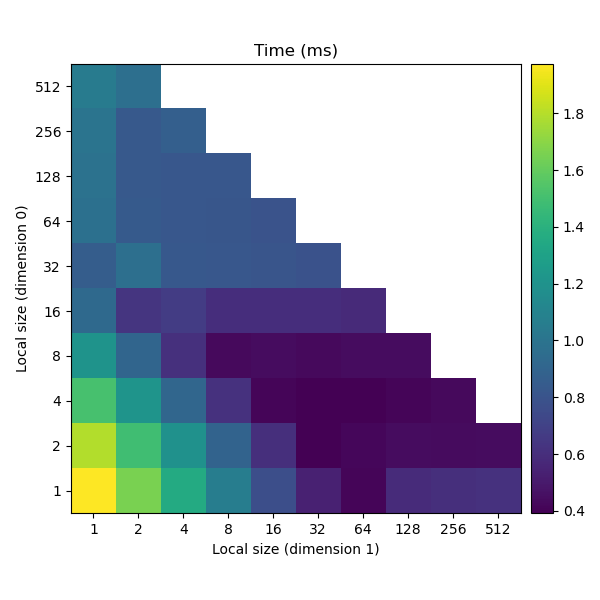

In [16]:
!make; 
data_mat_mult=local_opt.run_problem(["./mat_mult.exe","-gpu", "1"])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
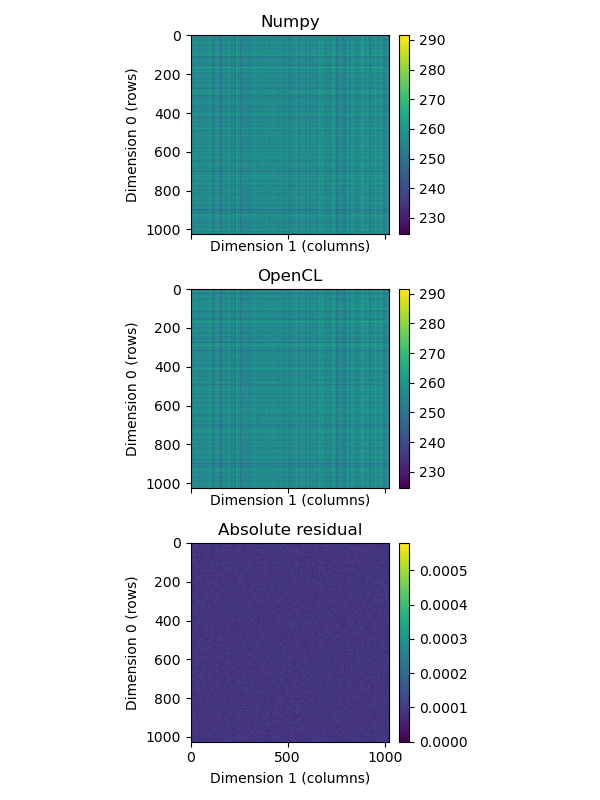

In [17]:
mat_mul.check_data()

### Access to vector elements

Buffer allocations of memory can be interpreted as vectors up to 16 elements. This is a potential source of optimisation because 

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_shmem_transp.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using local memory in matrix multiplication.</figcaption>
</figure>

In [7]:
!make; ./mat_mult_local_transpose_vector.exe -gpu 1

make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 
	 global memory size: 12635 MB
	    max buffer size: 3158 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Time for event "Running transpose kernel": 0.015 ms
Time for event "Running mat_mul_transp_vec kernel": 1.101 ms


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
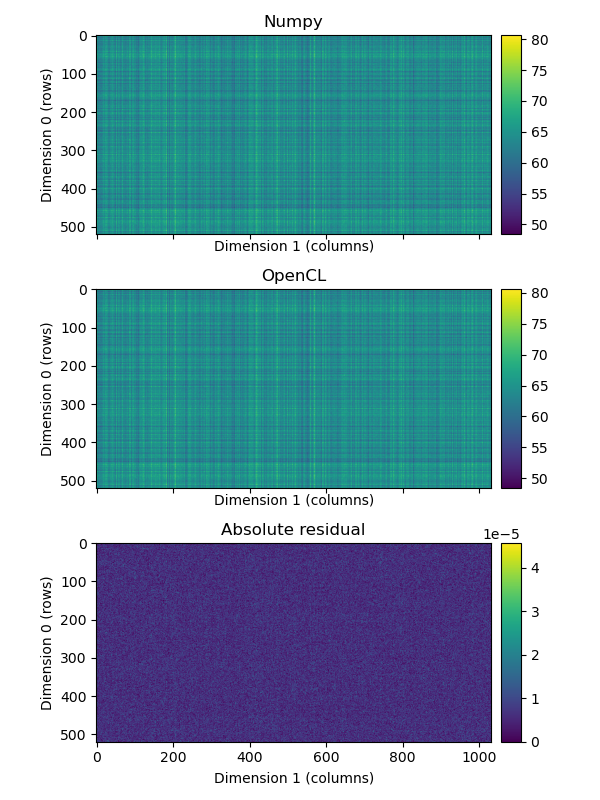

In [8]:
# Import axes machinery
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read in the output from OpenCL
C_ocl = np.fromfile("array_C.dat", dtype=dtype).reshape((NROWS_C, NCOLS_C))

# Make plots
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True, sharey=True)

# Data to plot
data = [C, C_ocl, np.abs(C-C_ocl)]

# Labels to plot
labels = ["Numpy", "OpenCL", "Absolute residual"]

for n, value in enumerate(data):
    # Plot the graph
    ax = axes[n]
    im = ax.imshow(value)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Set labels on things
    ax.set_xlabel("Dimension 1 (columns)")
    ax.set_ylabel("Dimension 0 (rows)")
    ax.set_title(labels[n])

    # Put a color bar on the plot
    plt.colorbar(mappable=im, cax=cax)

fig.tight_layout()
plt.show()